# DataCamp (Python)

##           Ensemble Methods in Python        


In [1]:
data_folder = "C:/Users/Admin/Dropbox/Python/ficheiros/DataCamp/DataCamp - Ensemble Methods in Python/"

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, BaggingRegressor, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, VotingRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from mlxtend.classifier import StackingClassifier
from mlxtend.regressor import StackingRegressor

from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

##    CHAPTER 1  - Combining Multiple Models


#### Exercício 1 - Introduction to ensemble methods

In [4]:
%%script false
#vídeo

# Choosing the best model
# - DT, LR, K-NN ---> Combined model with possibly better accuracy

# Technologies and method
# from sklearn.ensemble import MetaEstimator

# Base estimators
est1 = Model1()
est2 = Model2()
estN = ModelN()

# Meta estimator
est_combined = MetaEstimator(estimators=[est1, est2, ..., estN], # Additional parameters)
    
# Train and test
est_combined.fit(X_train, y_train)
pred = est_combined.predict(X_test)

Couldn't find program: 'false'


Exercício 2

In [5]:
# Exploring Google apps data

# The first dataset you'll work with contains information about the ratings of around 10,800 apps on the Google Play store.
# It has been preloaded into a DataFrame called ratings. There are 13 features that describe a given app, such as 'Category'
# and 'Price'. The goal is to use this information to predict the rating of an app, which can range from 1 to 5.

ratings = pd.read_csv(data_folder + "googleplaystore.csv")

print(ratings.describe(), "\n")  # --> there are some faulty ratings: at least 1 (max) with 19

print(ratings.info())

ratings.head()  

            Rating
count  9367.000000
mean      4.193338
std       0.537431
min       1.000000
25%       4.000000
50%       4.300000
75%       4.500000
max      19.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Exercício 3

In [6]:
# working the dataset

# Reviews: convert '3M' for example to 3000000
ratings['Reviews'] = ratings['Reviews'].apply(lambda x: float(x[:-1])*10**6 if str(x).upper()[-1]=='M' else float(x))

# 'Size': the same, and also replace the text 'Varies with device' with 0, and '1,000+' with 1000
ratings['Size'] = ratings['Size'].replace('Varies with device', 0)
ratings['Size'] = ratings['Size'].replace('1,000+', 1000)
ratings['Size'] = ratings['Size'].apply(lambda x: float(x[:-1])*10**6 if str(x).upper()[-1]=='M'
                                                  else (float(x[:-1])*10**3 if str(x)[-1]=='k' else float(x)))

# Installs: erase '+', 'Free' to 0 and convert to float
ratings['Installs'] = [i.replace(',', '') for i in ratings.Installs]
ratings['Installs'] = ratings['Installs'].replace('Free', 0)
ratings['Installs'] = ratings['Installs'].apply(lambda x: float(x[:-1]) if str(x)[-1]=='+' else float(x))

# Type: replace missing values and 'Free' with 0, 'Paid' with 1
ratings['Type'] = ratings['Type'].replace('Free', 0).replace('0', 0).replace('Paid', 1).replace(np.nan, 0)

# Price: replace 'Everyone' with 0, remove '$' and convert all to float
ratings['Price'] = ratings['Price'].replace('Everyone', 0).replace('0', 0)
ratings['Price'] = ratings['Price'].apply(lambda x: float(x[1:]) if str(x)[0]=='$' else float(x))

# Content Rating: replace 'Teen' with 13, 'Everyone'&'Unrated'&nan with 0, 'Adults only 18+' with 18, 
#                         'Everyone 10+' with 10 and 'Mature 17+' with 17
ratings['Content Rating'] = ratings['Content Rating'].replace('Teen', 13).replace('Everyone', 0).replace('Unrated', 0) \
                                                     .replace(np.nan, 0).replace('Adults only 18+', 18) \
                                                     .replace('Everyone 10+', 10).replace('Mature 17+', 17)

# Rating (target variable): replace missing values with 0
ratings['Rating'] = ratings['Rating'].fillna(0)

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            10841 non-null float64
Reviews           10841 non-null float64
Size              10841 non-null float64
Installs          10841 non-null float64
Type              10841 non-null float64
Price             10841 non-null float64
Content Rating    10841 non-null int64
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 1.1+ MB


In [7]:
# Predicting the rating of an app

# To do this, you'll use scikit-learn's DecisionTreeRegressor. (dt are building blocks of many ensemble methods).
# We'll use the MAE (mean absolute error) as the evaluation metric. This metric is highly interpretable, as it represents
# the average absolute difference between actual and predicted ratings.
# All required modules have been pre-imported for you. The features and target are available in the variables X and y, 
# respectively.

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

X = ratings[['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating']]
y = ratings['Rating']

#########################################################################################################

# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the regressor
reg_dt = DecisionTreeRegressor(min_samples_leaf=3, min_samples_split=9, random_state=500)

# Fit to the training set
reg_dt.fit(X_train, y_train)

# Evaluate the performance of the model on the test set
y_pred = reg_dt.predict(X_test)

print('MAE: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print("""As the MAE is around 0.61, the error of the model is, on average, less than one rating point away from the
actual value.""")
mae_reg_dt = mean_absolute_error(y_test, y_pred) #para mais tarde comparar

MAE: 0.610
As the MAE is around 0.61, the error of the model is, on average, less than one rating point away from the
actual value.


#### Exercício 4 - Voting

In [8]:
#vídeo

# Voting - Ask the audience - wisdom of the crowd (Collective intelligence)

# Classification: Majority voting
#  - Majority Voting: Odd number of classiers (3+)

# To Voting to be effective:
#  --> Diverse: different algorithms or datasets
#  --> Independent and uncorrelated (!)
#  - Aggregate individual knowledge and predictions

print("Voting works only for classification problems.")

# Voting ensemble using scikit-learn
from sklearn.ensemble import VotingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create the individual models
clf_knn = KNeighborsClassifier(5)
clf_dt = DecisionTreeClassifier()
clf_lr = LogisticRegression(solver='lbfgs', multi_class='auto')

# Create voting classifier
clf_voting = VotingClassifier(estimators=[('knn', clf_knn), ('dt', clf_dt), ('lr', clf_lr)])

# Fit it to the training set and predict
clf_voting.fit(X_train, y_train)

y_pred = clf_voting.predict(X_test)


Voting works only for classification problems.


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Exercício 5

In [9]:
# Choosing the best model

# data
pokemon = pd.read_csv(data_folder + "Pokemon.csv")
X = pokemon[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']]
y = pokemon['Legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_dt = DecisionTreeClassifier()
clf_lr = LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='auto')

print("""As the classes here are imbalanced - only 65 of the 800 Pokémon in the dataset are legendary - we'll use 
F1-Score to evaluate the performance.

F1-Score (the harmonic mean of precision and recall): 2 *  (precision*recall) / (precison + recall).
precision: tp / (tp + fp)      |    recall: tp / (tp + fn)""")

print("\n============================================================================================================\n")

from sklearn.metrics import f1_score

##########################################################################################

# For each classifier, fit and predict
pred_lr = clf_lr.fit(X_train, y_train).predict(X_test)
pred_dt = clf_dt.fit(X_train, y_train).predict(X_test)
pred_knn = clf_knn.fit(X_train, y_train).predict(X_test)

# Evaluate the performance of each model
score_lr = f1_score(pred_lr, y_test)
score_dt = f1_score(pred_dt, y_test)
score_knn = f1_score(pred_knn, y_test)

# Print the scores
print("f1-score_lr: {}".format(score_lr))
print("f1-score_dt: {}".format(score_dt))
print("f1-score_knn: {}\n".format(score_knn))

clf_scores = [score_lr, score_dt, score_knn]
classifiers = ['LogisticRegression', 'DecisionTreeClassifier', 'KNeighborsClassifier']

print("The model which performs best on the test set is the {}.".format(classifiers[np.argmax(clf_scores)]))


As the classes here are imbalanced - only 65 of the 800 Pokémon in the dataset are legendary - we'll use 
F1-Score to evaluate the performance.

F1-Score (the harmonic mean of precision and recall): 2 *  (precision*recall) / (precison + recall).
precision: tp / (tp + fp)      |    recall: tp / (tp + fn)


f1-score_lr: 0.5882352941176471
f1-score_dt: 0.6956521739130435
f1-score_knn: 0.47619047619047616

The model which performs best on the test set is the DecisionTreeClassifier.


Exercício 6

In [10]:
# Assembling your first ensemble

from sklearn.ensemble import VotingClassifier

# Instantiate the individual models
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_lr = LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='auto')
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)

# Create and fit the voting classifier
clf_vote = VotingClassifier(estimators=[('knn', clf_knn), ('lr', clf_lr), ('dt', clf_dt)])

clf_vote.fit(X_train, y_train)


VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('lr',
                              LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2'...
                                      

Exercício 7

In [11]:
# Evaluating your ensemble

from sklearn.metrics import classification_report

# Calculate the predictions using the voting classifier
pred_vote = clf_vote.predict(X_test)

# Calculate the F1-Score of the voting classifier
score_vote = f1_score(pred_vote, y_test)
print('F1-Score: {:.3f}\n'.format(score_vote))

# Calculate the classification report
report = classification_report(y_test, pred_vote)
print(report)


F1-Score: 0.583

              precision    recall  f1-score   support

       False       0.98      0.95      0.97       150
        True       0.50      0.70      0.58        10

    accuracy                           0.94       160
   macro avg       0.74      0.83      0.77       160
weighted avg       0.95      0.94      0.94       160



#### Exercício 8 - Averaging (Soft Voting)

In [12]:
#vídeo

# Averaging (Soft Voting)

# Properties
# - Classication & Regression problems
# - Soft Voting: Mean
#    - Regression: mean of predicted values
#    - Classication: mean of predicted probabilities
# Need at least 2 estimators

print("""VotingClassifier parameters:

voting : str, {‘hard’, ‘soft’} (default=’hard’)
If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the
argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

weights : array-like, shape (n_classifiers,), optional (default=`None`)
Sequence of weights (float or int) to weight the occurrences of predicted class labels (hard voting) or class probabilities
before averaging (soft voting). Uses uniform weights if None.""")

# Averaging ensemble with scikit-learn: example

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor


# Create an averaging classifier
clf_voting = VotingClassifier(estimators=[('knn', clf_knn), ('dt', clf_dt), ('lr', clf_lr)],
                              voting='soft', weights=[1, 2, 1])


# Create an averaging regressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

reg_linear = LinearRegression()
reg_knn = KNeighborsRegressor()
reg_rf = RandomForestRegressor()

reg_voting = VotingRegressor(estimators=[('linear_reg', reg_linear), ('knn_reg', reg_knn), ('rf', reg_rf)],
                             weights=[2, 1, 1])

print("\n===============================================\n")
print("VotingRegressor doesn't have the voting parameter.")


VotingClassifier parameters:

voting : str, {‘hard’, ‘soft’} (default=’hard’)
If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the
argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

weights : array-like, shape (n_classifiers,), optional (default=`None`)
Sequence of weights (float or int) to weight the occurrences of predicted class labels (hard voting) or class probabilities
before averaging (soft voting). Uses uniform weights if None.


VotingRegressor doesn't have the voting parameter.


Exercício 9

In [13]:
# Journey to Westeros

# If you're a Game of Thrones fan, you might already know all about the fictional world of Westeros and the characters 
# that inhabit it. Regardless, it's important to explore a new dataset before doing any modeling.
# The dataset is loaded into the environment and available to you as got, the commonly used acronym for Game of Thrones.

# The target variable here is 'actual'. It represents whether a character is alive (1) or not (0). 
# Explore it using .describe(). What can you conclude about it?

got = pd.read_csv(data_folder + "character-predictions.csv")

print("There are no missing values in the target ('actual') variable.")

got.describe()

There are no missing values in the target ('actual') variable.


,S.No,actual,pred,alive,plod,male,dateOfBirth,DateoFdeath,book1,book2,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,433.000000,444.000000,1946.000000,1946.000000,...,23.000000,276.000000,1946.000000,1946.000000,433.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,973.500000,0.745632,0.687050,0.634470,0.365530,0.619219,1577.364896,2950.193694,0.198356,0.374615,...,0.652174,0.778986,0.141829,0.460946,-1293.563510,0.305755,0.074512,0.059096,0.089584,0.745632
std,561.906131,0.435617,0.463813,0.312637,0.312637,0.485704,19565.414460,28192.245529,0.398864,0.484148,...,0.486985,0.415684,0.348965,0.498601,19564.340993,1.383910,0.262669,0.235864,0.160568,0.435617
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-298001.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,487.250000,0.000000,0.000000,0.391250,0.101000,0.000000,240.000000,282.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.013378,0.000000
50%,973.500000,1.000000,1.000000,0.735500,0.264500,1.000000,268.000000,299.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.033445,1.000000
75%,1459.750000,1.000000,1.000000,0.899000,0.608750,1.000000,285.000000,299.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,50.000000,0.000000,0.000000,0.000000,0.086957,1.000000
max,1946.000000,1.000000,1.000000,1.000000,1.000000,1.000000,298299.000000,298299.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,100.000000,15.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# preparing GoT dataset
got.loc[:, got.columns != 'age'] = got.loc[:, got.columns != 'age'].fillna(0)   # Replaced NA values with 0 (except 'age')
got['age'] = got['age'].apply(lambda x: 0 if x < 0 else x)                      # Replace negative values of age with 0
got['age'] = got['age'].fillna(0)                                               #  Replace NA values of age with the mean.

Exercício 10

In [15]:
# Predicting GoT deaths

X = got[['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 
         'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'boolDeadRelations',
         'isPopular', 'popularity']]
y = got['actual']

from sklearn.svm import SVC

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##################################################################################

# Build the individual models
clf_lr = LogisticRegression(class_weight='balanced', solver='lbfgs')
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf_svm = SVC(probability=True, class_weight='balanced', gamma='scale', random_state=500)

# List of (string, estimator) tuples
estimators = [('lr', clf_lr), ('dt', clf_dt), ('svm', clf_svm)]


# individual scores
for clf_name, clf in estimators:   
    clf.fit(X_train, y_train)    
    y_pred = clf.predict(X_test)
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))


# Build and fit an averaging classifier
clf_avg = VotingClassifier(estimators=estimators, voting='soft')

clf_avg.fit(X_train, y_train)

# Evaluate model performance
acc_avg = accuracy_score(y_test,  clf_avg.predict(X_test))
print('VotingClassifier Accuracy: {:.2f}'.format(acc_avg))


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


lr : 0.690
dt : 0.787
svm : 0.749


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


VotingClassifier Accuracy: 0.80


Exercício 11

In [16]:
# Soft vs. hard voting

# Three individual classifiers:
clf_lr = LogisticRegression(class_weight='balanced', solver='lbfgs')
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Your task is to try both voting and averaging to determine which is better.

#############################################################

# List of (string, estimator) tuples
estimators = [('lr', clf_lr), ('dt', clf_dt), ('knn', clf_knn)]

# Build and fit a voting classifier (default voting=Hard)
clf_vote = VotingClassifier(estimators=estimators)
clf_vote.fit(X_train, y_train)

# Build and fit an averaging classifier
clf_avg = VotingClassifier(estimators=estimators, voting='soft')
clf_avg.fit(X_train, y_train)

# Evaluate the performance of both models
acc_vote = accuracy_score(y_test, clf_vote.predict(X_test))
acc_avg = accuracy_score(y_test,  clf_avg.predict(X_test))
print('(Hard) Voting: {:.2f}\n(Soft/Averaging) Voting: {:.2f}'.format(acc_vote, acc_avg))

print("\nWhen feasible, try both approaches and choose the better performing one.")

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(Hard) Voting: 0.78
(Soft/Averaging) Voting: 0.78

When feasible, try both approaches and choose the better performing one.


# CHAPTER 2 - Bagging

#### Exercício 1 - The strength of "weak" models

In [17]:
#vídeo 

# "Weak" model
#  - Voting and Averaging:
#  - Small number of estimators
#  - Fine-tuned estimators
#  - Individually trained

# New concept: "weak" estimator

# Properties of "weak" models
#  Weak estimator 
#  - Performance better than random guessing
#  - Light model
#  - Low training and evaluation time

# Examples of "weak" models
#  - Decision tree: small depth
#  - LogisticRegression
#  - LinearRegression
#  - Other restricted models


Exercício 2

In [18]:
# Restricted and unrestricted decision trees

# Pokémon dataset
pokemon = pd.read_csv(data_folder + "Pokemon.csv")
X = pokemon[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']]
y = pokemon['Legendary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For this exercise, we will revisit the Pokémon dataset from the last chapter. Recall that the goal is to predict whether
# or not a given Pokémon is legendary.

print("""Here, you will build two separate decision tree classifiers. In the first, you will specify the parameters 
'min_sample_leaf' and 'min_sample_split', but not a 'maximum depth', so that the tree can fully develop without any 
restrictions.
In the second, you will specify some constraints by limiting the depth of the decision tree. By then comparing the two 
models, you'll better understand the notion of a "weak" learner.""")

from sklearn.metrics import confusion_matrix

#######################################################################
print("\n===============================================================================\n")

# Build UNRESTRICTED decision tree
clf = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf.fit(X_train, y_train)

# Predict the labels
pred = clf.predict(X_test)

# Print the confusion matrix
cm = confusion_matrix(y_test, pred)
print('Confusion matrix (UNRESTRICTED model):\n', cm)

# Print the F1 score
score = f1_score(y_test, pred)
print('F1-Score (UNRESTRICTED model): {:.3f}'.format(score))

###########################################################################################

# Build restricted decision tree
clf = DecisionTreeClassifier(max_depth=4, max_features=2, random_state=500)
clf.fit(X_train, y_train)

# Predict the labels
pred = clf.predict(X_test)

# Print the confusion matrix
cm = confusion_matrix(y_test, pred)
print('\nConfusion matrix (RESTRICTED model):\n', cm)

# Print the F1 score
score = f1_score(y_test, pred)
print('F1-Score (RESTRICTED model): {:.3f}'.format(score))

print("\n===============================================================================\n")

print("Notice how the restricted decision tree performs worse, and is only slightly better than random guessing.")


Here, you will build two separate decision tree classifiers. In the first, you will specify the parameters 
'min_sample_leaf' and 'min_sample_split', but not a 'maximum depth', so that the tree can fully develop without any 
restrictions.
In the second, you will specify some constraints by limiting the depth of the decision tree. By then comparing the two 
models, you'll better understand the notion of a "weak" learner.


Confusion matrix (UNRESTRICTED model):
 [[143   7]
 [  3   7]]
F1-Score (UNRESTRICTED model): 0.583

Confusion matrix (RESTRICTED model):
 [[146   4]
 [  5   5]]
F1-Score (RESTRICTED model): 0.526


Notice how the restricted decision tree performs worse, and is only slightly better than random guessing.


Exercício 3

In [19]:
# "Weak" decision tree

# In the previous exercise you built two decision trees. Which one is fine-tuned and which one is "weak"?

print("""Model A is a fine-tuned decision tree, with a decent performance on its own. Model B is 'weak', restricted in 
height and with performance just above 50%.""")

Model A is a fine-tuned decision tree, with a decent performance on its own. Model B is 'weak', restricted in 
height and with performance just above 50%.


#### Exercício 4 - Bootstrap aggregating

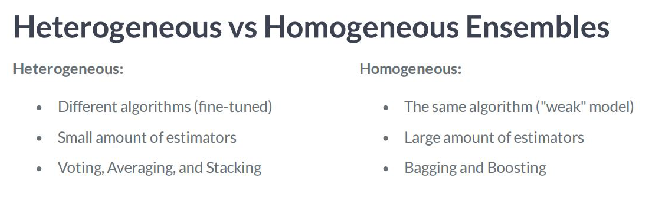

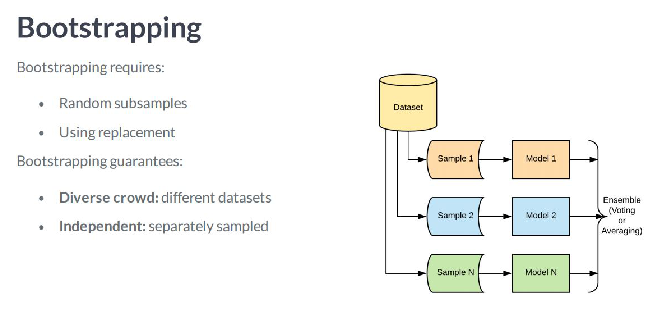

In [20]:
#vídeo

# Heterogeneous vs Homogeneous Ensembles
image = plt.imread(data_folder + "het_hom_ensembles.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-0.5, right=1.5, top=1, wspace=0.01, hspace=0)
plt.show()

##############

# Condorcet's Jury Theorem (Marquis de Condorcet, French philosopher and mathematician)
# Adding more models improves the performance ofthe ensemble (Voting or Averaging), and this approaches 1 (100%).

#############

# Bootstrapping
image = plt.imread(data_folder + "bootstrapping.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-0.5, right=1.5, top=1, wspace=0.01, hspace=0)
plt.show()

# Pros and cons of bagging
# Pros
#  - Bagging usually reduces variance
#  - Overtting can be avoided by the ensemble itself
#  - More stability and robustness
# Cons
#  - It is computationally expensive

Exercício 5

In [21]:
# Training with bootstrapping

print("""Let's now build a "weak" decision tree classifier and train it on a sample of the training set drawn with 
replacement. This will help you understand what happens on every iteration of a bagging ensemble.
To take one sample, use pandas' .sample() method, which has a replace parameter (True or False).

This represents one iteration of a bagging ensemble.""")

# Take a sample of X_train and (according) y_train with replacement
X_train_sample = X_train.sample(frac=1, replace=True, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Build a "weak" Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=4, max_features=2, random_state=500)

# Fit the model to the training sample
clf.fit(X_train_sample, y_train_sample)


Let's now build a "weak" decision tree classifier and train it on a sample of the training set drawn with 
replacement. This will help you understand what happens on every iteration of a bagging ensemble.
To take one sample, use pandas' .sample() method, which has a replace parameter (True or False).

This represents one iteration of a bagging ensemble.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=500, splitter='best')

Exercício 6

##### Bagging Classifier - manually

In [22]:
# A first attempt at bagging

# You've seen what happens in a single iteration of a bagging ensemble. Now let's build a custom bagging model.
# Define functions and manually build a custom bagging model:

###########################################

# Takes a sample with replacement, build a "weak" decision tree (see parameters) and fits to the sample training set
def build_decision_tree(X_train, y_train, random_state=None):
    X_train_sample = X_train.sample(frac=1, replace=True, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
    clf = DecisionTreeClassifier(max_depth=4, random_state=500)
    clf.fit(X_train_sample, y_train_sample)
    return clf

# Find majority element
def majority_element(List):
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency > counter): 
            counter = curr_frequency 
            num = i 
    return num

# predict 
def predict_voting(classifiers_list, X):
    # Makes the individual predictions and combines them using "Voting"
    i_predictions = []
    [i_predictions.append(i.predict(X)) for i in classifiers_list]
        
    # "Hard Voting" (for classifiers - majority)
    clf_voting = []    
    for j in range(len(i_predictions[0])):
        clf_voting.append(majority_element([i[j] for i in i_predictions]))
    
    return clf_voting

print("Atenção aos parâmetros que utilizei - por exemplo 'max_depth' no DecisionTreeClassifier.")

Atenção aos parâmetros que utilizei - por exemplo 'max_depth' no DecisionTreeClassifier.


In [23]:
# Build the list of individual models
clf_list = []

for i in range(21):
    clf_list.append(build_decision_tree(X_train, y_train, random_state=i))

# Predict on the test set
pred = predict_voting(clf_list, X_test)

# Print the F1 score
print('F1 score: {:.3f}'.format(f1_score(y_test, pred)))
custom_bagging_score = f1_score(y_test, pred)

F1 score: 0.522


#### Exercício 7 - BaggingClassifier: nuts and bolts

In [24]:
#vídeo

# BaggingClassier
print("BaggingClassifier")
from sklearn.ensemble import BaggingClassifier

# Instantiate the base estimator ("weak" model)
clf_dt = DecisionTreeClassifier(max_depth=3)

# Build the Bagging classifier with 5 estimators
clf_bag = BaggingClassifier(base_estimator=clf_dt, n_estimators=5)  # 5 classification trees

# Fit the Bagging model to the training set & Predict on the test set
clf_bag.fit(X_train, y_train)
y_pred = clf_bag.predict(X_test)

#######

# BaggingRegressor
print("BaggingRegressor\n")
from sklearn.ensemble import BaggingRegressor

# Instantiate the base estimator ("weak" model)
reg_lr = LinearRegression(normalize=False)

# Build the Bagging regressor with 10 estimators
reg_bag = BaggingRegressor(base_estimator=reg_lr, n_estimators=10)  # default is 10

# Fit the Bagging model to the training set & Make predictions on the test set
reg_bag.fit(X_train, y_train)
y_pred = reg_bag.predict(X_test)

#########################

# Out-of-bag score
print("Out-of-bag score")

# Calculate the individual predictions using all estimators for which an instance was out of the sample
# Combine the individual predictions
# Evaluate the metric on those predictions:
# - Classication: accuracy
# - Regression: R^2

clf_bag = BaggingClassifier(base_estimator=clf_dt, oob_score=True)
clf_bag.fit(X_train, y_train)
print("BaggingClassifier oob_score: ", clf_bag.oob_score_)

BaggingClassifier
BaggingRegressor

Out-of-bag score
BaggingClassifier oob_score:  0.9375


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


Exercício 8

In [25]:
# Bagging: the scikit-learn way

# Pokémon dataset - You obtained an F1 score of around 0.56 with your custom bagging ensemble. 
# Will BaggingClassifier() beat it?

# Instantiate the base model
clf_dt = DecisionTreeClassifier(max_depth=4)

# Build and train the Bagging classifier
clf_bag = BaggingClassifier(base_estimator=clf_dt, n_estimators=21, random_state=500)
clf_bag.fit(X_train, y_train)

# Predict the labels of the test set
pred = clf_bag.predict(X_test)

# Show the F1-score
print('F1-Score: {:.3f}'.format(f1_score(y_test, pred)))

print("""\nThe sklearn BaggingClassifier got a better performance than our custom ensemble ({} vs {}) and also using 
only 21 estimators (and same 'max_depth' parameter).""".format(round(f1_score(y_test, pred), 2), 
                                                               round(custom_bagging_score, 2)))

F1-Score: 0.667

The sklearn BaggingClassifier got a better performance than our custom ensemble (0.67 vs 0.52) and also using 
only 21 estimators (and same 'max_depth' parameter).


Exercício 9

In [26]:
# Checking the out-of-bag score

# Build and train the bagging classifier
clf_bag = BaggingClassifier(base_estimator=clf_dt, n_estimators=21, oob_score=True, random_state=500)
clf_bag.fit(X_train, y_train)

# Print the out-of-bag score
print('OOB-Score: {:.3f}'.format(clf_bag.oob_score_))

# Evaluate the performance on the test set to compare
pred = clf_bag.predict(X_test)
print('test set Accuracy: {:.3f}'.format(accuracy_score(y_test, pred)))

OOB-Score: 0.933
test set Accuracy: 0.963


#### Exercício 10 - Bagging parameters: tips and tricks

Additional parameters in bootstrapping:
  - max_samples: the number of samples to draw for each estimator.

  - max_features: the number of features to draw for each estimator. (default: 1) --> otherwise, it's a Random Forest
      - Classification ~ sqrt(number_of_features) 
      - Regression ~ number_of_features / 3 --> see original paper discovery or:
          --> ver  https://datascience.stackexchange.com/questions/23666/how-many-features-to-sample-using-random-forests
  - bootstrap : whether samples are drawn with replacement.
      - True --> max_samples = 1.0 (default)
      - False --> max_samples < 1.0 

Random Forests: special case of Bagging, where the base estimator is a decision tree. For this, it is recommended
to use sklearn's RandomForestClassifier or Regressor instead, as these are specifically designed for trees.
It combines the models using averaging, instead of voting, so there is no need to use an odd number of estimators.

Tree-specic parameters:
 - max_depth
 -

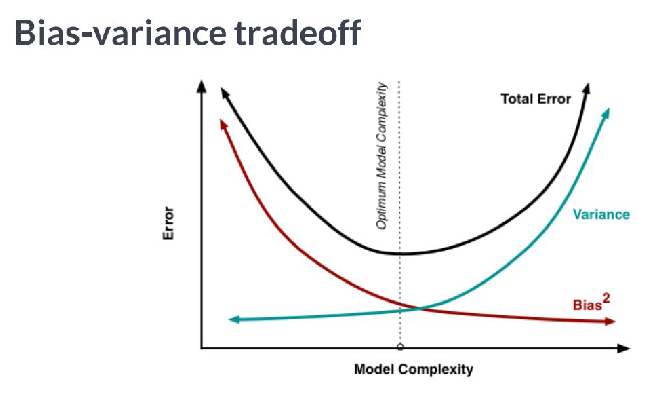

In [27]:
#vídeo

# Basic parameters for bagging
#  - base_estimator
#  - n_estimators
#  - oob_score

# ADDITIONAL PARAMETERS

print("""Additional parameters in bootstrapping:
  - max_samples: the number of samples to draw for each estimator.

  - max_features: the number of features to draw for each estimator. (default: 1) --> otherwise, it's a Random Forest
      - Classification ~ sqrt(number_of_features) 
      - Regression ~ number_of_features / 3 --> see original paper discovery or:
          --> ver  https://datascience.stackexchange.com/questions/23666/how-many-features-to-sample-using-random-forests
  - bootstrap : whether samples are drawn with replacement.
      - True --> max_samples = 1.0 (default)
      - False --> max_samples < 1.0 \n""")

##################

print("========================================================================================================")

# Random forest
print("""Random Forests: special case of Bagging, where the base estimator is a decision tree. For this, it is recommended
to use sklearn's RandomForestClassifier or Regressor instead, as these are specifically designed for trees.
It combines the models using averaging, instead of voting, so there is no need to use an odd number of estimators.\n""")

# Classication
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier() # parameters...

# Regression
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor() # parameters...

print("""Tree-specic parameters:
 - max_depth
 - min_samples_split
 - min_samples_leaf
 - class_weight ( “balanced” )""")

print("\n========================================================================================================")

print("Bias-Variance tradeoff:")
image = plt.imread(data_folder + "bias_variance.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-0.5, right=1.5, top=1, wspace=0.01, hspace=0)
plt.show()

Exercício 11

In [28]:
# Exploring the UCI SECOM data

# To round out this chapter and solidify your understanding of bagging, it's time to work with a new dataset. 
# This data is from a semi-conductor manufacturing process, obtained from the UCI Machine Learning Repository: uci_secom.

uci_secom = pd.read_csv(data_folder + "uci-secom.csv")

# Each row represents a production entity. The features are measurements from sensors or points in the process. 
# The labels represent whether the entity passes (1) or fails (-1) the test.
# The target is the 'Pass/Fail' column. 
# Use the .value_counts() and .describe() methods to check this variable. What do you notice?

print(uci_secom['Pass/Fail'].value_counts(), "\n")
print(uci_secom['Pass/Fail'].describe(), "\n")

print("There is evidence of high class imbalance in the target.")

-1    1463
 1     104
Name: Pass/Fail, dtype: int64 

count    1567.000000
mean       -0.867262
std         0.498010
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max         1.000000
Name: Pass/Fail, dtype: float64 

There is evidence of high class imbalance in the target.


Exercício 12

In [29]:
# preparing data
uci_secom = uci_secom.fillna(0)
X = uci_secom.drop(['Pass/Fail', 'Time'], axis=1)
y = uci_secom['Pass/Fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [30]:
# A more complex bagging model

# As the target has a high class imbalance, use a "balanced" logistic regression as the base estimator here.

# Build a balanced logistic regression
clf_lr = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, random_state=42)

# Build and fit a bagging classifier
clf_bag = BaggingClassifier(base_estimator=clf_lr, oob_score=True, max_features=10, random_state=500)
clf_bag.fit(X_train, y_train)

# Evaluate the accuracy on the test set and show the out-of-bag score
pred = clf_bag.predict(X_test)
print('Accuracy:  {:.2f}'.format(accuracy_score(y_test, pred)))
print('OOB-Score: {:.2f}'.format(clf_bag.oob_score_))

# Print the confusion matrix
print("\n", confusion_matrix(y_test, pred), "\n")

print("Not bad for an initial model, with an accuracy ~{} and unbiased predictions for the test set. See oob_score_."\
      .format(round(accuracy_score(y_test, pred), 2)))

Accuracy:  0.69
OOB-Score: 0.67

 [[419 167]
 [ 27  14]] 

Not bad for an initial model, with an accuracy ~0.69 and unbiased predictions for the test set. See oob_score_.


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


Exercício 13

In [31]:
# Tuning bagging hyperparameters

# While you can easily build a bagging classifier using the default parameters, it is highly recommended that you tune
# these in order to achieve optimal performance. Ideally, these should be optimized using K-fold cross-validation.
# In this exercise, let's see if we can improve model performance by modifying the parameters of the bagging classifier.

# Build a balanced logistic regression
clf_base = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, random_state=42)

# Build and fit a bagging classifier with custom parameters
clf_bag = BaggingClassifier(base_estimator=clf_base, n_estimators=500, max_features=10, max_samples=0.65, bootstrap=False,
                            random_state=500)
clf_bag.fit(X_train, y_train)

# Calculate predictions and evaluate the accuracy on the test set
y_pred = clf_bag.predict(X_test)
print('Accuracy:  {:.2f}'.format(accuracy_score(y_test, y_pred)))

# Print the classification report
print(classification_report(y_test, y_pred))
print("With the correct hyperparameters the model can get a better performance.")

Accuracy:  0.78
              precision    recall  f1-score   support

          -1       0.95      0.80      0.87       586
           1       0.12      0.39      0.19        41

    accuracy                           0.78       627
   macro avg       0.54      0.60      0.53       627
weighted avg       0.90      0.78      0.83       627

With the correct hyperparameters the model can get a better performance.


# Chapter 3 - Boosting

#### Exercício 1 - The effectiveness of gradual learning

In [32]:
#vídeo

# Collective vs gradual learning

# Collective Learning
#  - Principle: wisdom of the crowd
#  -  Independent estimators
#  -  Learning the same task for the same goal
#  -  Parallel building

####################################

# Gradual Learning
#  - Principle: iterative learning
#  -  Dependent estimators
#  -  Learning different tasks for the same goal
#  -  Sequential building

# gradual learning:
# 1. First attempt (initial model)
# 2. Feedback (model evaluation)
# 3. Correct errors (subsequent model)

# Fitting to noise

# White noise
#  - Uncorrelated errors
#  - Unbiased errors and with constant variance
# Improvement tolerance
#  - If Performance difference < improvement threshold: stop training


Exercício 2

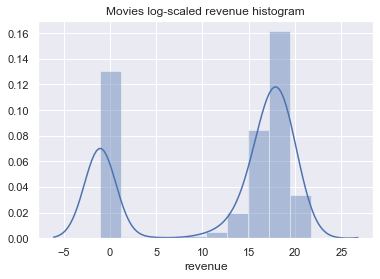

It appears that even after the log-transformation there are many zero values. 
We can also notice a bi-modal distribution.


count    4.803000e+03
mean     8.226064e+07
std      1.628571e+08
min      3.500000e-01
25%      3.500000e-01
50%      1.917000e+07
75%      9.291719e+07
max      2.787965e+09
Name: revenue, dtype: float64

In [33]:
# Introducing the movie database

# Throughout this chapter, you'll be working with the TMDb (The Movie Database). 
# This contains metadata on around 5000 movies. The dataset is loaded and available to you as movies.
# Your main objective is to predict movie revenue - more specifically, log-revenue, which is the normalized version of the
# revenue feature. Use the .describe() method to explore this feature. You can also inspect the histogram.
# What can you conclude?

# dataset
movies = pd.read_csv(data_folder + "tmdb_5000_movies.csv")

# replace 0 with a value close to 0 just to build histogram log-scaled
movies.loc[movies[movies['revenue'] == 0].index, 'revenue'] = 0.35

# histogram of revenue
sns.distplot(np.log(movies['revenue']))
plt.title("Movies log-scaled revenue histogram")
plt.show()

print("""It appears that even after the log-transformation there are many zero values. 
We can also notice a bi-modal distribution.""")

# describe
movies['revenue'].describe()

Exercício 3

In [34]:
# Exploring movie features

# In the rest of this chapter, you will use boosting algorithms to build models that predict the log-revenue of movies 
# based on the following features: 'budget', 'popularity', 'runtime', 'vote_average', and 'vote_count'. 
# There are many more features, but these will be of primary interest. 
# Having explored the target in the previous exercise, it's now time to explore these features.

# The features of interest have been loaded into the features variable. Use the .describe() method to explore it. 
# What do you notice?

features = movies[['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']]

print(features.describe())
print("""\nThe only feature with missing values is 'runtime'. Also, all features are on different scales, and therefore
need to be normalized.""")
features.head()

             budget   popularity      runtime  vote_average    vote_count
count  4.803000e+03  4803.000000  4801.000000   4803.000000   4803.000000
mean   2.904504e+07    21.492301   106.875859      6.092172    690.217989
std    4.072239e+07    31.816650    22.611935      1.194612   1234.585891
min    0.000000e+00     0.000000     0.000000      0.000000      0.000000
25%    7.900000e+05     4.668070    94.000000      5.600000     54.000000
50%    1.500000e+07    12.921594   103.000000      6.200000    235.000000
75%    4.000000e+07    28.313505   118.000000      6.800000    737.000000
max    3.800000e+08   875.581305   338.000000     10.000000  13752.000000

The only feature with missing values is 'runtime'. Also, all features are on different scales, and therefore
need to be normalized.


,budget,popularity,runtime,vote_average,vote_count
0,237000000,150.437577,162.0,7.2,11800
1,300000000,139.082615,169.0,6.9,4500
2,245000000,107.376788,148.0,6.3,4466
3,250000000,112.312950,165.0,7.6,9106
4,260000000,43.926995,132.0,6.1,2124


Exercício 4

In [35]:
# Predicting movie revenue

# Let's begin the challenge of predicting movie revenue by building a simple linear regression to predict the log-revenue 
# of movies based on the 'budget' feature. The metric you will use here is the RMSE (root mean squared error).
# To calculate this using scikit-learn, you can use the mean_squared_error() function from the sklearn.metrics class and 
# then take its square root using numpy.
# The movies dataset has been loaded for you and split into train and test sets. Additionally, the missing values have been 
# replaced with zeros. 

from sklearn.metrics import mean_squared_error
movies.fillna(0, inplace=True)
X = np.array(movies['budget']).reshape(-1, 1)  # como é só uma variável temos que fazer o reshape
y = movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####

print("""LinearRegression - parameter
 - normalize : boolean, optional, default False
This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression
by subtracting the mean and dividing by the l2-norm. If you wish to standardize, please use StandardScaler before calling
fit on an estimator with normalize=False.
Note: The l2-norm is known as the Euclidean norm/distance.

==================================================================================================================\n""")

# Build and fit linear regression model
reg_lm = LinearRegression(normalize=True)
reg_lm.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_lm.predict(X_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE: {:.3f}'.format(rmse))


LinearRegression - parameter
 - normalize : boolean, optional, default False
This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression
by subtracting the mean and dividing by the l2-norm. If you wish to standardize, please use StandardScaler before calling
fit on an estimator with normalize=False.
Note: The l2-norm is known as the Euclidean norm/distance.


RMSE: 97137084.337


Exercício 5

In [36]:
# primeiro vou só ver como é com 'popularity':
X = np.array(movies['popularity']).reshape(-1, 1)
y = movies['revenue']
X_train_pop, X_test_pop, y_train_pop, y_test_pop = train_test_split(X, y, test_size=0.2, random_state=42)

reg_lm = LinearRegression(normalize=True)
reg_lm.fit(X_train_pop, y_train_pop)
pred = reg_lm.predict(X_test_pop)

rmse = np.sqrt(mean_squared_error(y_test_pop, pred))
print('RMSE: {:.3f}'.format(rmse))

RMSE: 127988629.682


In [37]:
# Boosting for predicted revenue

# Let's see if we can improve this using an iteration of boosting.

# You'll build another linear regression, but this time **the target values are the errors from the base model**, 
# calculated as follows:

pred_train = reg_lm.predict(X_train)
pred_test = reg_lm.predict(X_test)

y_train_error = pred_train - y_train
y_test_error = pred_test - y_test

# For this model you'll also use 'popularity' as an additional feature, hoping that it can provide informative patterns 
# than with the 'budget' feature alone. This is available to you as X_train_pop and X_test_pop.

In [38]:
# Fit a linear regression model to the previous errors
reg_error = LinearRegression(normalize=True)
reg_error.fit(X_train_pop, y_train_error)

# Calculate the predicted errors on the test set
pred_error = reg_error.predict(X_test_pop)

# Evaluate the updated performance
rmse_error = np.sqrt(mean_squared_error(y_test_error, pred_error))
print('RMSE: {:.3f}'.format(rmse_error))

print("""\nFitting a linear regression to try to fix the errors of the previous model provided a lower RMSE. 
This is boosting in action.""")

RMSE: 129937204616528.594

Fitting a linear regression to try to fix the errors of the previous model provided a lower RMSE. 
This is boosting in action.


#### Exercício 6 - Adaptive boosting: award winning model

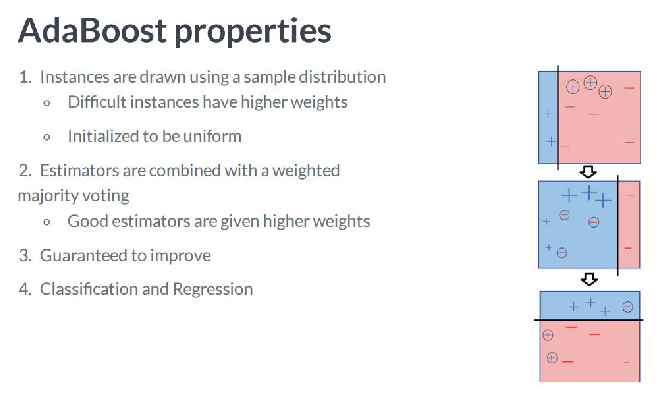

Default parameters:
 - base_estimator=DecisionTreeClassifier(max_depth=1) / DecisionTreeRegressor(max_depth=3)
 - n_estimators=50
 - learning_rate=1
 
AdaBoostClassifier: 
Learning rate shrinks the contribution of each classifier by learning_rate. 
There is a trade-off between 'n_estimators' and 'learning_rate'

AdaBoostRegressor: 
loss : {‘linear’, ‘square’, ‘exponential’}, optional (default=’linear’)
The loss function to use when updating the weights after each boosting iteration.


In [39]:
#vídeo

# About AdaBoost:
#  - Proposed by Yoav Freund and Robert Schapire (1997)
#  - Winner of the Gödel Prize in (2003)
#  - The first practical boosting algorithm
#  - Highly used and well known ensemble method

image = plt.imread(data_folder + "adaboost.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-0.5, right=1.5, top=1, wspace=0.01, hspace=0)
plt.show()

##########

print("""Default parameters:
 - base_estimator=DecisionTreeClassifier(max_depth=1) / DecisionTreeRegressor(max_depth=3)
 - n_estimators=50
 - learning_rate=1
 """)

# AdaBoost classifier with scikit-learn
from sklearn.ensemble import AdaBoostClassifier

# Default parameters
clf_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                             n_estimators=50,
                             learning_rate=1)

print("""AdaBoostClassifier: 
Learning rate shrinks the contribution of each classifier by learning_rate. 
There is a trade-off between 'n_estimators' and 'learning_rate'""")

#########

# AdaBoost regressor with scikit-learn
from sklearn.ensemble import AdaBoostRegressor

# Default parameters
reg_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                            n_estimators=50,
                            learning_rate=1,
                            loss='linear')

print("""\nAdaBoostRegressor: 
loss : {‘linear’, ‘square’, ‘exponential’}, optional (default=’linear’)
The loss function to use when updating the weights after each boosting iteration.""")

Exercício 7

In [40]:
# Your first AdaBoost model

# In the previous lesson you built models to predict the log-revenue of movies. You started with a simple linear regression
# and got an RMSE of 7.34. Then, you tried to improve it with an iteration of boosting, getting to a lower RMSE of 7.28.
# In this exercise, you'll build your first AdaBoost model - an AdaBoostRegressor - in an attempt to improve performance 
# even further. The movies dataset has been loaded and split into train and test sets.
# Here you'll be using the 'budget' and 'popularity' features.

X = movies[['budget', 'popularity']]
y = movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##########

from sklearn.ensemble import AdaBoostRegressor

# Instantiate a normalized linear regression model
reg_lm = LinearRegression(normalize=True)

# Build and fit an AdaBoost regressor
reg_ada = AdaBoostRegressor(base_estimator=reg_lm, n_estimators=12, random_state=500)
reg_ada.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE: {:.3f}'.format(rmse))

print("\nThis first AdaBoost ensemble model produced a RMSE better than the custom model.")

RMSE: 137546852.652

This first AdaBoost ensemble model produced a RMSE better than the custom model.


Exercício 8

In [41]:
# Tree-based AdaBoost regression

# AdaBoost models are usually built with decision trees as the base estimators. Let's give this a try now and see if model
# performance improves even further.
# We'll use twelve estimators as before to have a fair comparison. There's no need to instantiate the decision tree as it 
# is the base estimator by default.

# Build and fit a tree-based AdaBoost regressor
reg_ada = AdaBoostRegressor(n_estimators=12, random_state=500)

reg_ada.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE: {:.3f}'.format(rmse))

print("\nUsing a decision tree instead of a linear regression as the base estimator reduced the RMSE a lot.")

RMSE: 100202890.098

Using a decision tree instead of a linear regression as the base estimator reduced the RMSE a lot.


Exercício 9

In [42]:
# Making the most of AdaBoost

# As you have seen, for predicting movie revenue, AdaBoost gives the best results with decision trees as the base estimator.
# In this exercise, you'll specify some parameters to extract even more performance. In particular, you'll use a lower 
# learning rate to have a smoother update of the hyperparameters. Therefore, the number of estimators should increase.
# Additionally, the following features have been added to the data: 'runtime', 'vote_average', and 'vote_count'.

X = movies[['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']]
y = movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####################

# Build and fit an AdaBoost regressor
reg_ada = AdaBoostRegressor(n_estimators=100, learning_rate=0.01, random_state=500)
reg_ada.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE: {:.3f}'.format(rmse))

print("\nEven significant further improvement of the RMSE with these parameters (and variables).")
rmse_adaboost = rmse

RMSE: 79953949.281

Even significant further improvement of the RMSE with these parameters (and variables).


#### Exercício 10 - Gradient boosting

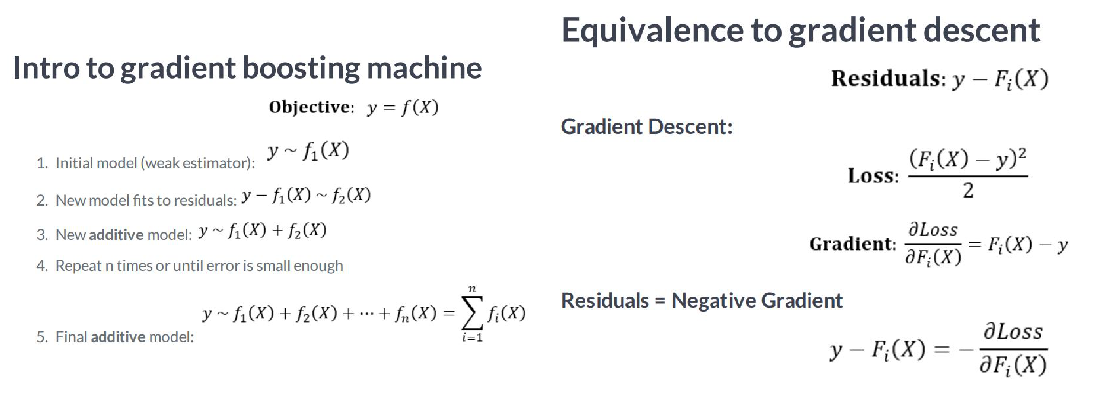

Default parameters (in both):
 - n_estimators=100, learning_rate=0.1, max_depth=3,
 - min_samples_split=2, min_samples_leaf=1, max_features=None
 
GradientBoostingClassifier
GradientBoostingRegressor

Default parameters:
 - n_estimators=100, learning_rate=0.1, max_depth=3,
 - min_samples_split=2, min_samples_leaf=1, max_features=None
 

The final result is an additive model. This is a peculiarity of Gradient Boosting, as the individual estimators
are not combined through voting or averaging, but by addition. This is because on the first model is included in the 
target variable and the rest are estimates of the residual errors. 

It's called gradient boosting since it is equivalent as applying gradient descent as the optimization algorithm.

Note: we don't define the base_estimator since GradientBoosting is implemented and optimized with trees as the individual
      estimators.


In [43]:
#vídeo

# Gradient Boosting has a proven track record of winning many machine learning competitions

plt.subplot(1, 2, 1)
image = plt.imread(data_folder + "gradient_boosting_0.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplot(1, 2, 2)
image = plt.imread(data_folder + "gradient_boosting_1.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-0.7, right=2.5, top=1, wspace=0.01, hspace=0)
plt.show()

print("""Default parameters (in both):
 - n_estimators=100, learning_rate=0.1, max_depth=3,
 - min_samples_split=2, min_samples_leaf=1, max_features=None
 """)

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Default parameters
clf_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, 
                                     min_samples_split=2, min_samples_leaf=1, max_features=None)


# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

reg_gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,
                                    min_samples_split=2, min_samples_leaf=1, max_features=None)


print("GradientBoostingClassifier")
print("GradientBoostingRegressor")

print("""\nDefault parameters:
 - n_estimators=100, learning_rate=0.1, max_depth=3,
 - min_samples_split=2, min_samples_leaf=1, max_features=None
 """)

print("""\nThe final result is an additive model. This is a peculiarity of Gradient Boosting, as the individual estimators
are not combined through voting or averaging, but by addition. This is because on the first model is included in the 
target variable and the rest are estimates of the residual errors. 

It's called gradient boosting since it is equivalent as applying gradient descent as the optimization algorithm.

Note: we don't define the base_estimator since GradientBoosting is implemented and optimized with trees as the individual
      estimators.""")

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Default parameters
clf_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,
                                     min_samples_split=2, min_samples_leaf=1, max_features=None)


# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Default parameters
clf_gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,
                                    min_samples_split=2, min_samples_leaf=1, max_features=None)


Exercício 11

In [44]:
# Revisiting Google app reviews

# We're now going to leverage gradient boosting to perform *sentiment analysis*.

# Remember the app ratings dataset from the first chapter? We'll now work with a related dataset for user reviews.
# This dataset contains the first 100 most relevant reviews for each app. Our goal is to build a model based on these 
# reviews that predicts the Sentiment as being 'Positive', 'Neutral', or 'Negative'.
# The dataset is available to you as reviews, and the target here is the 'Sentiment' column. 
# Explore the data in the IPython Shell, and then select the correct statement from the options below.

reviews = pd.read_csv(data_folder + "googleplaystore_user_reviews.csv")

print(reviews['Sentiment'].value_counts())
print("\nMissing values in 'Sentiment':", reviews['Sentiment'].isna().count())
print("After checking the head of the target and the frequency of values we can see that there are many missing reviews.")

reviews.head()

Positive    23998
Negative     8271
Neutral      5163
Name: Sentiment, dtype: int64

Missing values in 'Sentiment': 64295
After checking the head of the target and the frequency of values we can see that there are many missing reviews.


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


Exercício 12

In [45]:
# Data set pre-processing

# 1) Remove reviews with missing values.
# 2) Select data from the top 5 apps.
# 3) Select a random subsample of 500 reviews.
# 4) Remove "stop words" from the reviews.
# 5) Transform the reviews into a matrix, in which each feature represents the frequency of a word in a review.

# 1) Remove reviews with missing values.
reviews = reviews.drop(reviews[reviews['Sentiment'].isna()].index, axis=0)

# 2) Select data from the top 5 apps.
top_5_apps = reviews['App'].value_counts()[:5].index
reviews = reviews.loc[reviews['App'].isin(top_5_apps)]

# 3) Select a random subsample of 500 reviews.
reviews = reviews.sample(n=500, replace=False, random_state=1)

# 4) Remove "stop words" from the reviews.
from nltk.corpus import stopwords
english_stops = stopwords.words('english')
reviews['Translated_Review'] = reviews['Translated_Review'].apply(
    lambda x: ' '.join([word for word in str(x).lower().split() if word not in (english_stops)]))

# 5) Transform the reviews into a matrix, in which each feature represents the frequency of a word in a review.
from sklearn.feature_extraction.text import CountVectorizer

docs = list(reviews['Translated_Review'])
vec = CountVectorizer()
x = vec.fit_transform(docs)
X = pd.DataFrame(x.toarray(), columns=vec.get_feature_names())

#############################

# train, test, split
X # done 
y = reviews['Sentiment'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [46]:
# Sentiment analysis with GBM

# Build and fit a Gradient Boosting classifier
clf_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=500)
clf_gbm.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = clf_gbm.predict(X_test)

# Evaluate the performance based on the accuracy
acc = accuracy_score(y_test, pred)
print('Accuracy: {:.3f}'.format(acc))

# Get and show the Confusion Matrix
cm = confusion_matrix(y_test, pred)
print("\nconfusion_matrix:\n", cm)

print("""\nThe gradient boosting classifier was able to predict the sentiment of the reviews with an accuracy 
of {}""".format(acc))


Accuracy: 0.870

confusion_matrix:
 [[38  0  9]
 [ 1  2  1]
 [ 1  1 47]]

The gradient boosting classifier was able to predict the sentiment of the reviews with an accuracy 
of 0.87


#### Exercício 13 - Gradient boosting flavors

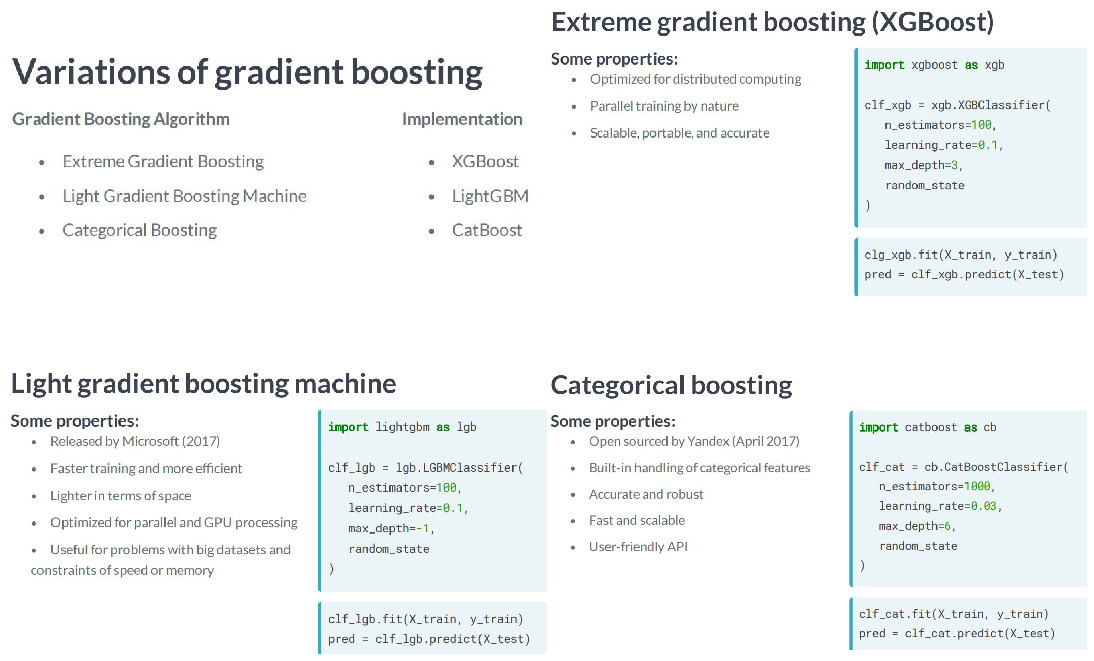

In [47]:
#vídeo

plt.subplot(2, 2, 1)
image = plt.imread(data_folder + "variations_gdboosting_0.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplot(2, 2, 2)
image = plt.imread(data_folder + "variations_gdboosting_1.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplot(2, 2, 3)
image = plt.imread(data_folder + "variations_gdboosting_2.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplot(2, 2, 4)
image = plt.imread(data_folder + "variations_gdboosting_3.jpg")      
plt.axis('off')                                            
plt.imshow(image)

plt.subplots_adjust(left=0, bottom=-1.5, right=2.5, top=1, wspace=0, hspace=0)
plt.show()

# Extreme gradient boosting (XGBoost)
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)

# Light gradient boosting machine
import lightgbm as lgb
clf_lgb = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=1)

# Categorical boosting
import catboost as cb
clf_cat = cb.CatBoostClassifier(n_estimators=1000, learning_rate=0.03, max_depth=6, random_state=1)


Exercício 14

In [48]:
# Movie revenue prediction with CatBoost

# Let's finish up this chapter on boosting by returning to the movies dataset. In this exercise, you'll build a 
# CatBoostRegressor to predict the log-revenue. Our best model so far is the AdaBoost model with a RMSE of 5.15.
# Will CatBoost beat AdaBoost? We'll try to use a similar set of parameters to have a fair comparison.
# Recall the features we have used: 'budget', 'popularity', 'runtime', 'vote_average' and 'vote_count'.

X = movies[['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']]
y = movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#############

import catboost as cb

# Build and fit a CatBoost regressor
reg_cat = cb.CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=500)
reg_cat.fit(X_train, y_train)

# Calculate the predictions on the set set
pred = reg_cat.predict(X_test)

# Evaluate the performance using the RMSE
rmse_cat = np.sqrt(mean_squared_error(y_test, pred))

print("""\nRMSE (CatBoost): {:.3f} | versus RMSE (AdaBoostRegressor): {:.3f}. It trained faster 
too.""".format(rmse_cat, rmse_adaboost))

0:	learn: 170746867.0781795	total: 75.2ms	remaining: 7.45s
1:	learn: 161592985.7938516	total: 97.7ms	remaining: 4.79s
2:	learn: 152002881.2554664	total: 124ms	remaining: 4s
3:	learn: 143407950.3091327	total: 156ms	remaining: 3.73s
4:	learn: 135966308.5936708	total: 212ms	remaining: 4.02s
5:	learn: 129101867.1110168	total: 241ms	remaining: 3.77s
6:	learn: 123652740.1345900	total: 300ms	remaining: 3.98s
7:	learn: 118396368.5582817	total: 349ms	remaining: 4.01s
8:	learn: 114279415.3915078	total: 390ms	remaining: 3.94s
9:	learn: 110252705.7534497	total: 416ms	remaining: 3.75s
10:	learn: 106596004.9817789	total: 464ms	remaining: 3.75s
11:	learn: 103603770.9266009	total: 483ms	remaining: 3.54s
12:	learn: 100821794.2366648	total: 568ms	remaining: 3.8s
13:	learn: 98260330.8780892	total: 611ms	remaining: 3.76s
14:	learn: 96163002.9457678	total: 632ms	remaining: 3.58s
15:	learn: 94508297.0181782	total: 681ms	remaining: 3.57s
16:	learn: 93045693.8465341	total: 714ms	remaining: 3.49s
17:	learn: 91

Exercício 15

In [49]:
# Boosting contest: Light vs Extreme

# While the performance of the CatBoost model is relatively good, let's try the two other flavors of boosting and see which
# one is better: the "Light" or the "Extreme" approach.
# CatBoost is highly recommended when there are categorical features. In this case, all features are numeric, therefore one
# of the other approaches might perform better.

import xgboost as xgb
import lightgbm as lgb

# Build and fit a XGBoost regressor
reg_xgb = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=500)
reg_xgb.fit(X_train, y_train)

# Build and fit a LightGBM regressor
reg_lgb = lgb.LGBMRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, seed=500)
reg_lgb.fit(X_train, y_train)

# Calculate the predictions and evaluate both regressors
pred_xgb = reg_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

pred_lgb = reg_lgb.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, pred_lgb))

print('\nExtreme: {:.3f}, Light: {:.3f}'.format(rmse_xgb, rmse_lgb))

print("\nWhile XGBoost got a better score, LightGBM is faster and lighter. CatBoost was good as well.")

[15:16:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Admin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Extreme: 91257927.750, Light: 70716781.508

While XGBoost got a better score, LightGBM is faster and lighter. CatBoost was good as well.


# Chapter 4 - Stacking

#### Exercício 1 - The intuition behind stacking

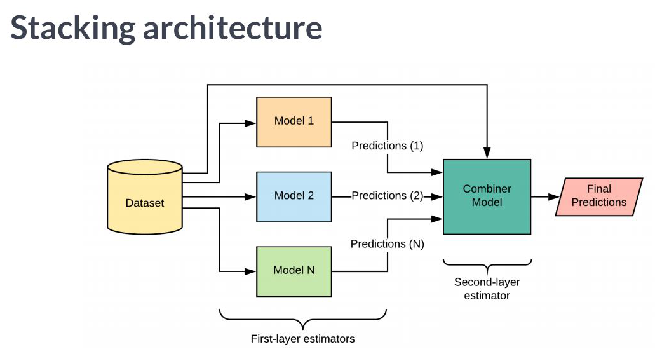

In [50]:
#vídeo

# Relay race for models --->  Passing the baton (como numa corrida) <--> Passing predictions

image = plt.imread(data_folder + "stacking.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-0.5, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

# Combiner model as anchor


Exercício 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

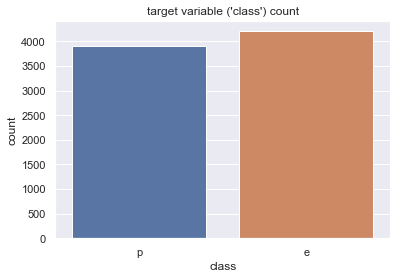

The target is binary, categorical, and balanced.


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [51]:
# Exploring the mushroom dataset

# In this chapter you'll work with a new dataset about North American mushrooms. Each mushroom is represented with physical
# features and classified as edible, poisonous, or unknown and not recommended. However, the unknown class was combined 
# with the poisonous one. The objective is to predict which mushrooms are edible based on their properties.

# The dataset is available to you as mushrooms, and the target is the 'class' column. Explore it in the IPython Shell and 
# select the correct statement from the options below.

# data set (tirei do UCI)
mushrooms = pd.read_excel(data_folder + "mushrooms.xlsx", header=None)
mushrooms.columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing',
                    'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                    'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 
                    'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

#################################################

print(mushrooms.info())

# target variable
sns.countplot(mushrooms['class'])
plt.title("target variable ('class') count")
plt.show()
print("The target is binary, categorical, and balanced.")

mushrooms.head()

Exercício 3

In [52]:
# Predicting mushroom edibility

# Now that you have explored the data, it's time to build a first model to predict mushroom edibility.
# As both the features and the target are categorical, these have been transformed into "dummy" binary variables for you.
# Let's begin with Naive Bayes (using scikit-learn's GaussianNB) and see how this algorithm performs on this problem.

X = pd.get_dummies(mushrooms.drop('class', axis=1))
y = mushrooms['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#####################

from sklearn.naive_bayes import GaussianNB

# Instantiate a Naive Bayes classifier
clf_nb = GaussianNB()

# Fit the model to the training set
clf_nb.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = clf_nb.predict(X_test)

# Evaluate the performance using the accuracy score
print("Accuracy: {:0.4f}".format(accuracy_score(y_test, pred)))


Accuracy: 0.9671


Exercício 4

In [53]:
# K-nearest neighbors for mushrooms

# The Gaussian Naive Bayes classifier did a really good job for being an initial model. Let's now build a new model to 
# compare it against the Naive Bayes.
# In this case, the algorithm to use is a 5-nearest neighbors classifier. As the dummy features create a high-dimensional 
# dataset, use the **Ball Tree** algorithm to make the model faster. Let's see how this model performs.

# Instantiate a 5-nearest neighbors classifier with 'ball_tree' algorithm
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')     # 'ball_tree' (to expedite the processing).

# Fit the model to the training set
clf_knn.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = clf_knn.predict(X_test)

# Evaluate the performance using the accuracy score
print("Accuracy: {:0.4f}".format(accuracy_score(y_test, pred)))
print("A more advanced model could improve the performance even further.")

Accuracy: 1.0000
A more advanced model could improve the performance even further.


#### Exercício 5 - Build your first stacked ensemble

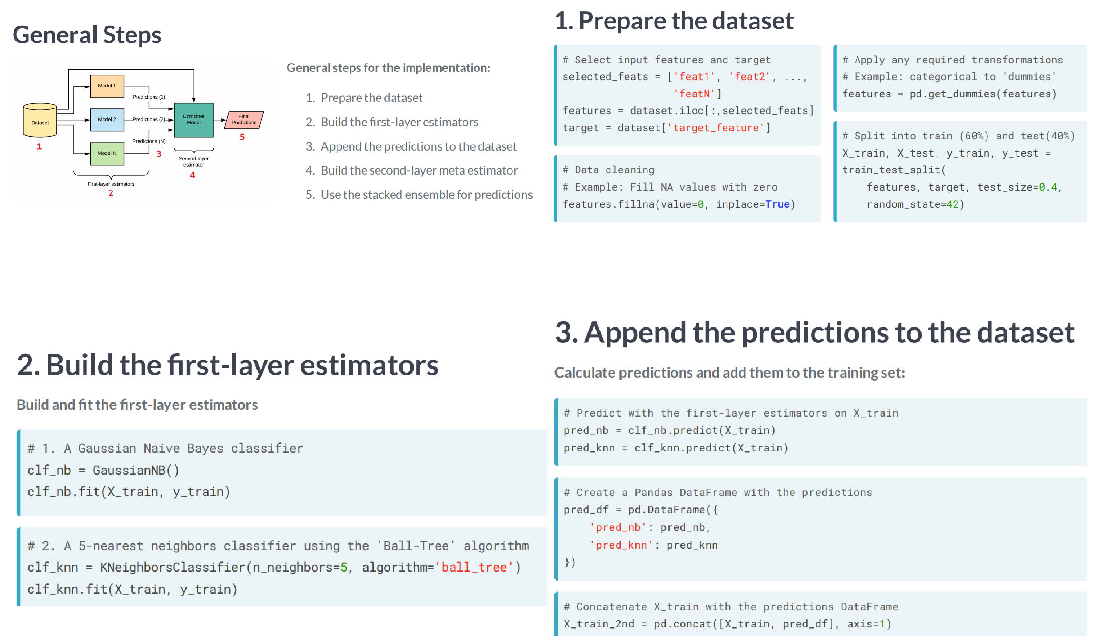

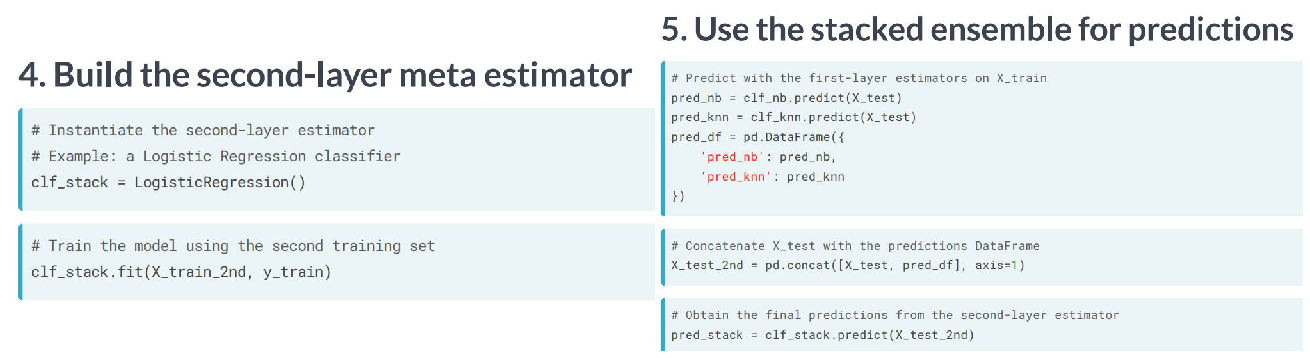

In [54]:
#vídeo

# Stacking models with scikit-learn

# Some reasons to build from scratch:
# 1. scikit-learn has no stacking implementation
# ---> 2. We will build stacking models from scratch
# 3. scikit-learn estimators can be used as a base

plt.subplot(2, 2, 1)
image = plt.imread(data_folder + "stacking_general.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplot(2, 2, 2)
image = plt.imread(data_folder + "stacking_1.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplot(2, 2, 3)
image = plt.imread(data_folder + "stacking_2.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplot(2, 2, 4)
image = plt.imread(data_folder + "stacking_3.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-1.5, right=2.5, top=1, wspace=0, hspace=0)
plt.show()

plt.subplot(1, 2, 1)
image = plt.imread(data_folder + "stacking_4.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplot(1, 2, 2)
image = plt.imread(data_folder + "stacking_5.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-2, right=3, top=1, wspace=0, hspace=0)
plt.show()


Exercício 6

In [55]:
# Applying stacking to predict app ratings

# In this exercise you'll start building your first Stacking ensemble from scratch. The dataset you'll use is the first one
# we used in Chapter 1. If you recall, the objective is to predict the rating of each app (from 1 to 5). 
# The input features we use are: Reviews, Size, Installs, Type, Price, and Content Rating.
# We already did step 1: prepare the dataset. It is available to you as apps. We cleaned the required features and replaced
# missing values with zeros.
# Now, you'll work on step 2: build the **first-layer estimators**.

apps = ratings
apps['Rating'] = apps['Rating'].astype(int)
X = apps[['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating']]
y = apps['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#########################################################################################################

# Build and fit a Decision Tree classifier
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf_dt.fit(X_train, y_train)

# Build and fit a 5-nearest neighbors classifier using the 'Ball-Tree' algorithm
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
clf_knn.fit(X_train, y_train)

# Evaluate the performance using the accuracy score
print('Decision Tree accuracy: {:0.4f}'.format(accuracy_score(y_test, clf_dt.predict(X_test))))
print('5-Nearest Neighbors accuracy: {:0.4f}'.format(accuracy_score(y_test, clf_knn.predict(X_test))))


Decision Tree accuracy: 0.6818
5-Nearest Neighbors accuracy: 0.6820


Exercício 7

In [56]:
# Building the second-layer classifier

# Now you'll work on the next two steps of the process.
# Step 3: Append the predictions to the dataset. The predictions with the first-layer estimators were already calculated: 
# pred_dt and pred_knn. You'll use these to create a DataFrame and append them to the training features.

pred_dt = clf_dt.predict(X_train)
pred_knn = clf_knn.predict(X_train)

# Step 4: Build the second-layer meta estimator. For this purpose you'll build the default DecisionTreeClassifier. This will
# take as input feature the concatenation of the original training features and the predictions from the first-layer 
# estimators.

# Create a Pandas DataFrame with the predictions
pred_df = pd.DataFrame({'pred_dt': pred_dt, 'pred_knn': pred_knn}, index=X_train.index)

# Concatenate X_train with the predictions DataFrame
X_train_2nd = pd.concat([X_train, pred_df], axis=1)

# Build the second-layer meta estimator
clf_stack = DecisionTreeClassifier(random_state=500)
clf_stack.fit(X_train_2nd, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=500, splitter='best')

Exercício 8

In [57]:
# Stacked predictions for app ratings

# Once the second-layer estimator is built you are ready for step 5: use the stacked ensemble for predictions.

# First, you need to prepare the *test set* for the meta-estimator. The predictions with the first-layer estimators on the 
# test set are available to you as: pred_dt and pred_knn.

pred_dt = clf_dt.predict(X_test)
pred_knn = clf_knn.predict(X_test)

# Like you did in the previous exercise, here you need to build the DataFrame from the predictions and concatenate it with 
# the testing features.
# Let's obtain the final predictions and see if there is any improvement in performance thanks to stacking.

# Create a Pandas DataFrame with the predictions
pred_df = pd.DataFrame({'pred_dt': pred_dt, 'pred_knn': pred_knn}, index=X_test.index)

# Concatenate X_test with the predictions DataFrame
X_test_2nd = pd.concat([X_test, pred_df], axis=1)

# Obtain the final predictions from the second-layer estimator
pred_stack = clf_stack.predict(X_test_2nd)

# Evaluate the new performance on the test set
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, pred_stack)))

print("""\nFinished building a first stacked ensemble from scratch. In addition, the performance improved to around 
{} accuracy.""".format(round(accuracy_score(y_test, pred_stack), 2)))

Accuracy: 0.6809

Finished building a first stacked ensemble from scratch. In addition, the performance improved to around 
0.68 accuracy.


#### Exercício 9 - Let's mlxtend it

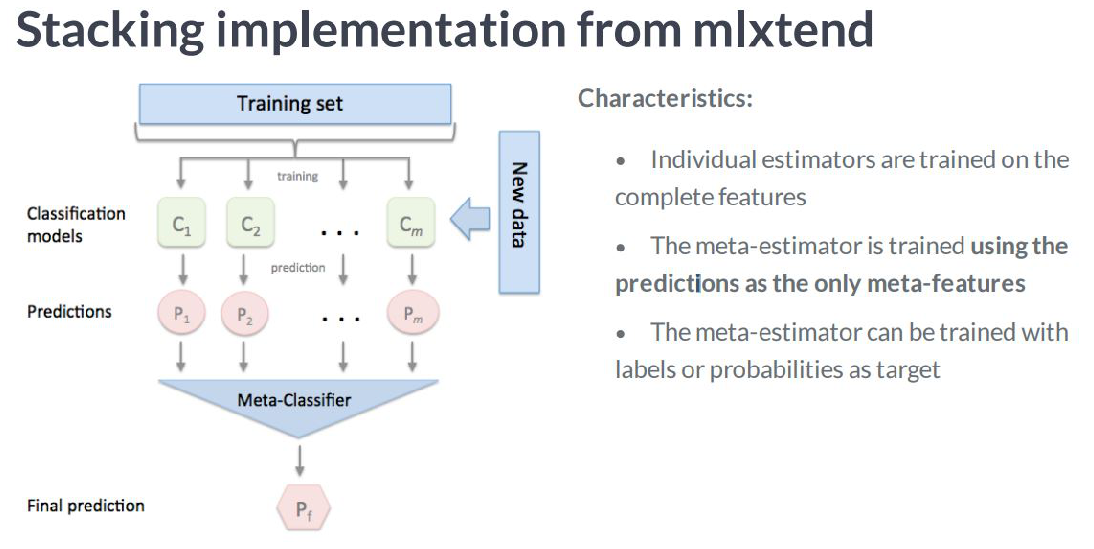

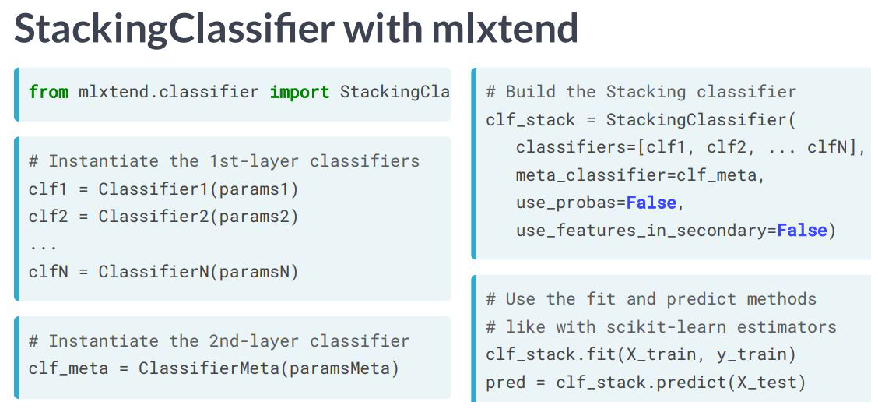

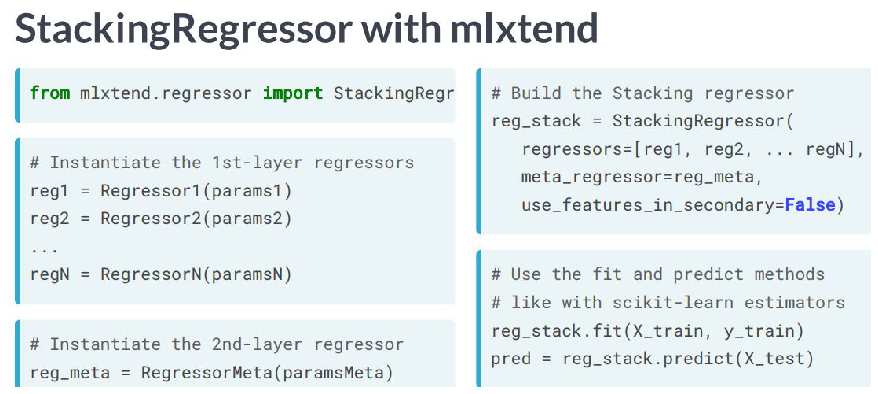


StackingClassifier
parameters: 
 - use_probas=False (default) --> If True, trains meta-classifier based on predicted probabilities instead of class labels.
 - use_features_in_secondary=False (default) --> If True, the meta-classifier will be trained both on the predictions of  
                                            the original classifiers and the original dataset. If False,the meta-classifier 
                                            will be trained only on the predictions of the original classifiers. 

StackingRegressor



In [58]:
#vídeo

# Mlxtend

# Machine Learning Extensions
# Utilities and tools for Data Science tasks:
#  - Feature selection
#  - Ensemble methods
#  - Visualization
#  - Model evaluation
# Intuitive and friendly API
# Compatible with scikit-learn estimators

# Stacking implementation from mlxtend
image = plt.imread(data_folder + "mlxtend_stacking.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-1, right=2.5, top=1, wspace=0, hspace=0)
plt.show()

# StackingClassifier with mlxtend & StackingRegressor with mlxtend
image = plt.imread(data_folder + "stacking_classifier.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

image = plt.imread(data_folder + "stacking_regressor.jpg")      
plt.axis('off')                                            
plt.imshow(image)
plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

from mlxtend.classifier import StackingClassifier
from mlxtend.regressor import StackingRegressor

print("\nStackingClassifier")
print("""parameters: 
 - use_probas=False (default) --> If True, trains meta-classifier based on predicted probabilities instead of class labels.
 - use_features_in_secondary=False (default) --> If True, the meta-classifier will be trained both on the predictions of  
                                            the original classifiers and the original dataset. If False,the meta-classifier 
                                            will be trained only on the predictions of the original classifiers. """)

print("\nStackingRegressor\n")

Exercício 10

In [59]:
# A first attempt with mlxtend

# It's time to start working with mlxtend. You'll continue using the app ratings dataset. As you have already built a 
# stacked ensemble model from scratch, you have a basis to compare with the model you'll now build with mlxtend.
# The dataset is loaded and available as apps.
# Let's see if mlxtend can build a model as good as or better than the custom ensemble classifier.

# Instantiate the first-layer classifiers
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9, random_state=500)
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')

# Instantiate the second-layer meta classifier
clf_meta = DecisionTreeClassifier(random_state=500)

# Build the Stacking classifier
clf_stack = StackingClassifier(classifiers=[clf_dt, clf_knn], meta_classifier=clf_meta, use_features_in_secondary=True)
clf_stack.fit(X_train, y_train)

# Evaluate the performance of the Stacking classifier
pred_stack = clf_stack.predict(X_test)
acc = accuracy_score(y_test, pred_stack)
print("Accuracy: {:0.4f}".format(accuracy_score(y_test, pred_stack)))

print("""\nThis first model with mlxtend was able to achieve a similar accuracy, of around {}.
""".format(round(accuracy_score(y_test, pred_stack), 2)))

Accuracy: 0.6809

This first model with mlxtend was able to achieve a similar accuracy, of around 0.68.



Exercício 11

In [60]:
# Back to regression with stacking

# In Chapter 1, we treated the app ratings as a regression problem, predicting the rating on the interval from 1 to 5. 
# So far in this chapter, we have dealt with it as a classification problem, rounding the rating to the nearest integer.
# To practice using the StackingRegressor, we'll go back to the regression approach.
# The MAE (mean absolute error) is the evaluation metric. In Chapter 1, the MAE was around 0.61. 
# Let's see if the stacking ensemble method can reduce that error.

from sklearn.linear_model import Ridge

# Instantiate the 1st-layer regressors
reg_dt = DecisionTreeRegressor(min_samples_leaf=11, min_samples_split=33, random_state=500)
reg_lr = LinearRegression(normalize=True)
reg_ridge = Ridge(random_state = 500)

# Instantiate the 2nd-layer regressor
reg_meta = LinearRegression()

# Build the Stacking regressor
reg_stack = StackingRegressor(regressors=[reg_dt, reg_lr, reg_ridge], meta_regressor=reg_meta)
reg_stack.fit(X_train, y_train)

# Evaluate the performance on the test set using the MAE metric
pred = reg_stack.predict(X_test)
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, pred)))

print("""Applying the Stacking regressor could reduce the error to around {}, an improvement over the initial model ({})
""".format(round(mean_absolute_error(y_test, pred), 2), round(mae_reg_dt, 2)))

MAE: 0.579
Applying the Stacking regressor could reduce the error to around 0.58, an improvement over the initial model (0.61)



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.18066e-18): result may not be accurate.
  overwrite_a=True).T


Exercício 12

In [61]:
# Mushrooms: a matter of life or death

# Let's conclude the course by revisiting the mushroom edibility problem. You'll try the stacking classifier to see if the
# score can be improved. As stacking uses a meta-estimator (second layer classifier) which attempts to correct predictions 
# from the first layer, some of the misclassified instances could be corrected. This is a very important problem, as the 
# edibility of a mushroom is a matter of life or death.
# The dataset has been loaded and split into train and test sets. Do you think stacking can help to predict the edibility 
# of a mushroom with greater confidence?

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X = pd.get_dummies(mushrooms.drop('class', axis=1))
y = LabelEncoder().fit_transform(mushrooms['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#######################################

# Create the first-layer models
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
clf_dt = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=15, random_state=500)
clf_nb = GaussianNB()

# Create the second-layer model (meta-model)
clf_lr = LogisticRegression(solver='lbfgs')

# Create and fit the stacked model
clf_stack = StackingClassifier(classifiers=[clf_knn, clf_dt, clf_nb], meta_classifier=clf_lr)
clf_stack.fit(X_train, y_train)

# Evaluate the stacked model’s performance
print("Accuracy: {:0.4f}".format(accuracy_score(y_test, clf_stack.predict(X_test))))

print("Now you can confidently predict the edibility of a mushroom.")

print("\nConfusion matrix:")
print(confusion_matrix(y_test, clf_stack.predict(X_test)))

Accuracy: 1.0000
Now you can confidently predict the edibility of a mushroom.

Confusion matrix:
[[1678    0]
 [   0 1572]]


#### Exercício 13 - end

In [62]:
# summary

# Fim